<a href="https://colab.research.google.com/github/gnitnaw/Programs/blob/master/Chapter9/NeuralNetPurePython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.7.13


# Section 9.5.1
## Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
print(np.__version__)

!rm polyreg.csv
!wget https://raw.github.com/gnitnaw/Programs/master/Chapter9/polyreg.csv

1.21.5
--2022-04-13 09:35:49--  https://raw.github.com/gnitnaw/Programs/master/Chapter9/polyreg.csv
Resolving raw.github.com (raw.github.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/gnitnaw/Programs/master/Chapter9/polyreg.csv [following]
--2022-04-13 09:35:49--  https://raw.githubusercontent.com/gnitnaw/Programs/master/Chapter9/polyreg.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3904 (3.8K) [text/plain]
Saving to: ‘polyreg.csv’

polyreg.csv         100%[===================>]   3.81K  --.-KB/s    in 0s      

2022-04-13 09:35:49 (40.9 MB/s) - ‘polyr

## Set random seed

In [3]:
np.random.seed(1234)

## Original Program

In [4]:
def initialize(p, w_sig = 1):
    W, b = [[]]*len(p), [[]]*len(p) 
    
    for l in range(1,len(p)):
       W[l]= w_sig * np.random.randn(p[l], p[l-1])
       b[l]= w_sig * np.random.randn(p[l], 1)
    return W,b

def list2vec(W,b):
    # converts list of weight matrices and bias vectors into one column vector
    b_stack = np.vstack([b[i] for i in range(1,len(b))] )
    W_stack = np.vstack(W[i].flatten().reshape(-1,1) for i in range(1,len(W))) 
    vec = np.vstack([b_stack, W_stack]) 
    return vec     
#%%
def vec2list(vec, p):
    # converts vector to weight matrices and bias vectors
    W, b = [[]]*len(p),[[]]*len(p) 
    p_count = 0 
    
    for l in range(1,len(p)): # construct bias vectors
        b[l] = vec[p_count:(p_count+p[l])].reshape(-1,1)
        p_count = p_count + p[l]
    
    for l in range(1,len(p)): # construct weight matrices
        W[l] = vec[p_count:(p_count + p[l]*p[l-1])].reshape((p[l], p[l-1]))
        p_count = p_count + (p[l]*p[l-1])
        
    return W, b      
#%%
def RELU(z,l):
    # RELU activation function: value and derivative 
    if l == L: return z, np.ones_like(z) # if last layer return identity 
    else: 
        val = np.maximum(0,z) # RELU function element-wise
        J = np.array(z>0, dtype = float) # derivative of RELU element-wise
        return val, J


#%%
def loss_fn(y,g):
    return (g - y)**2, 2 * (g - y) 


#%%
def feedforward(x,W,b): 
    a, z, gr_S = [0]*(L+1), [0]*(L+1), [0]*(L+1)
    
    a[0] = x.reshape(-1,1)
    for l in range(1,L+1):
        z[l] = W[l] @ a[l-1] + b[l] # affine transformation
        a[l], gr_S[l] = S(z[l],l) # activation function 
    return a, z, gr_S 

#%%
def backward(W,b,X,y): 
    n =len(y)
    delta = [0]*(L+1)
    dC_db, dC_dW = [0]*(L+1), [0]*(L+1)
    loss=0
    
    for i in range(n): # loop over training examples
        a, z, gr_S = feedforward(X[i,:].T, W, b)  
        cost, gr_C = loss_fn(y[i], a[L]) # cost i and gradient wrt g
        loss += cost/n  

        delta[L] = gr_S[L] @ gr_C    
        
        for l in range(L,0,-1): # l = L,...,1 
            dCi_dbl = delta[l]   
            dCi_dWl = delta[l] @  a[l-1].T
            
            # ---- sum up over samples ----
            dC_db[l] = dC_db[l] + dCi_dbl/n  
            dC_dW[l] = dC_dW[l] + dCi_dWl/n 
            # ----------------------------- 
            
            delta[l-1] =  gr_S[l-1] * W[l].T @ delta[l]
           
    return dC_dW, dC_db, loss


## main

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':


epoch | batch loss
----------------------------
1 :  998.6227975930176
1000 :  39.88357431735084
2000 :  27.99105485353483
3000 :  31.848700426460653
4000 :  30.1527418435443
5000 :  32.70812495794755
6000 :  39.495109409361696
7000 :  28.757997945519197
8000 :  40.19339051915107
9000 :  24.74476549172168
10000 :  34.412416175825044
entire training set loss =  28.546404908564824


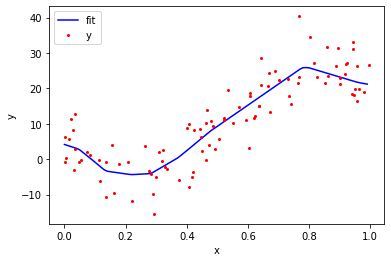

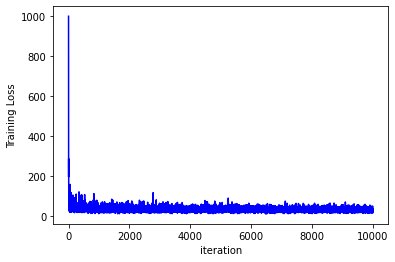

In [5]:
# import data
data = np.genfromtxt('polyreg.csv',delimiter=',')
X = data[:,0].reshape(-1,1)
y = data[:,1].reshape(-1,1)
    
    # Network setup 
p = [X.shape[1],20,20,1] # size of layers
L = len(p)-1             # number of layers
W,b = initialize(p) # initialize weight matrices and bias vectors    
S = RELU
        
batch_size = 20
lr = 0.005
beta = list2vec(W,b)
loss_arr = []
n = len(X)
num_epochs = 10000
print("epoch | batch loss")
print("----------------------------")
for epoch in range(1,num_epochs+1):
    batch_idx = np.random.choice(n,batch_size)
    batch_X = X[batch_idx].reshape(-1,1)
    batch_y=y[batch_idx].reshape(-1,1)      
    dC_dW, dC_db, loss = backward(W,b,batch_X,batch_y)
    d_beta = list2vec(dC_dW,dC_db)    
    loss_arr.append(loss.flatten()[0])
    if(epoch==1 or np.mod(epoch,1000)==0):
        print(epoch,": ",loss.flatten()[0])
    beta = beta - lr*d_beta
    W,b = vec2list(beta,p)
    
    # calculate the loss of the entire training set
dC_dW, dC_db, loss = backward(W,b,X,y)
print("entire training set loss = ",loss.flatten()[0])
    
    
#%%
xx = np.arange(0,1,0.01)
y_preds = np.zeros_like(xx)
    
for i in range(len(xx)): 
    a, _, _ = feedforward(xx[i],W,b)
    y_preds[i],  = a[L]

plt.plot(np.array(xx), y_preds, 'b',label = 'fit')    
plt.plot(X,y, 'r.', markersize = 4,label = 'y')

    
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()
    
plt.plot(np.array(loss_arr), 'b')
plt.xlabel('iteration')
plt.ylabel('Training Loss')
plt.show()
    
